In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from dateutil.relativedelta import relativedelta
from nltk import word_tokenize, sent_tokenize
from contextlib import redirect_stderr
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
from nltk import FreqDist
import pandas as pd
import numpy as np
import json
import glob
import io
import re
df_us_10k = pd.read_csv('D:\\data\\finance\\financial_statements\\us\\snp_meta_10k_09_19.csv', encoding='utf-8').drop_duplicates()
snp_gram_index = pd.read_csv('snp_gram_index_w2v.csv', encoding='utf-8')

In [121]:
def will_occurences(string):
    return len(re.findall('(?!A\s*|The\s*)(will)', string))

def file_to_string(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
          data = f.read()
    return data

def pre_process_raw_text(text):
    replacements = [
        ('&#8217', '\''),
        (' \[Text Block\]', '.'),
        ('No. ', 'No.'),
        ('<.*?>', ''),
        ('\s\s+', ' '),
        (';|\n|\t|\r|&#160|&#8221|&#8220', ' ')
    ]
    for old, new in replacements:
        text = re.sub(old, new, text)
        
    return text

# 10-k

In [4]:
#Count number of sentences
path = 'D:\\data\\finance\\financial_statements\\us\\EDGAR-raw\\'
length = []

for idx, row in df_us_10k_gram_index.iterrows():
    err = []
    err_flag = False
    try:
        string = file_to_string(path + row.adsh + '.txt')
        string = pre_process_raw_text(string)
    except:
        print('error on '+ str(row.adsh))
        err += [row.adsh]
        err_flag = True
    if err_flag:
        length += [None]
    else:
        length += [len([sent for sent in sent_tokenize(string) if len(sent.split())>5])]
    if idx % 1000 == 0:
        print(idx, length[idx])
df_us_10k_gram_index['num_sentence'] = length

0 2101
1000 6466
error on 0001274494-10-000029
2000 4112
error on 0000768251-10-000008
error on 0001274494-10-000039
3000 8135
4000 5622
5000 3250
6000 4809
7000 8972
8000 3816
9000 5737
error on 0000023217-13-000005
error on 0001123360-13-000031
10000 1678
11000 2332
12000 1837
13000 5662
14000 3260
15000 2548
16000 1681
17000 3117
18000 12493
19000 6710
20000 3765
21000 3535
22000 4447
23000 7426
24000 6629
25000 5471


C:\Users\sylim2357\anaconda3\envs\future-tense-mining\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [122]:
#Count grammatical words
path = 'D:\\data\\finance\\financial_statements\\us\\EDGAR-raw\\'
# grammatic_tokens = ['will', 'shall', 'going to', 'expect to', 'expected to', 'expecting to']
grammatic_tokens = ['will', 'shall', 'potential', 'prospective', 'plan', 'proposal', 'expect', 'likely', 'believe', 'feel', 'forecast', 'projection', 'intend']
gramm_tf = {token: [] for token in grammatic_tokens}
err = []
err_flag = False
for idx, row in df_us_10k.iterrows():
    try:
        string = file_to_string(path + row.adsh + '.txt')
    except:
        print('error on '+ str(row.adsh))
        err += [row.adsh]
        err_flag = True
    for token in gramm_tf.keys():
        if err_flag:
            gramm_tf[token] += [None]
        else:
            if token == 'will':
                gramm_tf[token] += [will_occurences(string)]
            else:
                gramm_tf[token] += [string.count(token)]
    err_flag = False
    if idx % 1000 == 0:
        print(idx)

for token in gramm_tf.keys():
    df_us_10k[token] = gramm_tf[token]

df_us_10k.to_csv('10k_grammatical_index.csv', encoding='utf-8', index=False)

0
1000
2000
error on 0001274494-10-000029
error on 0000768251-10-000008
error on 0001274494-10-000039
3000
4000
5000
6000
7000
8000
9000
error on 0000023217-13-000005
10000
error on 0001123360-13-000031
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000


In [125]:
#normalise & save
df_us_10k_gram_index = df_us_10k.merge(adsh_num_sen, on='adsh')
df_us_10k_gram_index['gramm_score'] = df_us_10k_gram_index[grammatic_tokens].sum(axis=1)/df_us_10k_gram_index['num_sentence']
df_us_10k_gram_index.to_csv('10k_us_grammatical_index.csv', encoding='utf-8', index=False)

In [130]:
df_us_10k_gram_index['filed'] = pd.to_datetime(df_us_10k_gram_index['filed'], format='%Y%m%d')
df_us_10k_gram_index.to_csv('10k_us_grammatical_index.csv', encoding='utf-8', index=False)

In [120]:
adsh_num_sen = pd.read_csv('..\\data\\10k_us_grammatical_index.csv', encoding='utf-8')[['adsh', 'num_sentence']]

# KOSPI

In [218]:
#KOSPI200 Grammatical words count
df_kr_10k_gram_index = pd.DataFrame(columns=['file'])
df_kr_10k_gram_index[['file']] = df_kospi_10k_1115[~df_kospi_10k_1115.Translated.isnull()][['File']]
df_kr_10k_gram_index['will'] = df_kospi_10k_1115['Translated'].dropna().apply(will_occurences)
df_kr_10k_gram_index['shall'] = df_kospi_10k_1115['Translated'].dropna().str.count('shall')
df_kr_10k_gram_index['going_to'] = df_kospi_10k_1115['Translated'].dropna().str.count('going to')
df_kr_10k_gram_index['expect_to'] = df_kospi_10k_1115['Translated'].dropna().str.count('expect to')
df_kr_10k_gram_index['expected_to'] = df_kospi_10k_1115['Translated'].dropna().str.count('expected to')
df_kr_10k_gram_index['expecting_to'] = df_kospi_10k_1115['Translated'].dropna().str.count('expecting to')
num_sentence = [len(sent) for sent in df_kospi_10k_1115['Translated'].dropna().apply(pre_process_raw_text).apply(sent_tokenize)]
df_kr_10k_gram_index['num_sentence'] = num_sentence
df_kr_10k_gram_index['gramm_score'] = df_kr_10k_gram_index[['will', 'shall', 'going_to', 'expected_to', 'expecting_to', 'expect_to']].sum(axis=1)/df_kr_10k_gram_index['num_sentence']

In [220]:
#KOSPI200 filed date
kospi_dl_link = []
files = glob.glob('D:\\kospi_200\\2011-2015\\config\\kospi200_download_link_*.json') + glob.glob('D:\\kospi_200\\2015-2019\\config\\\download_link_KOSPI\\download_link_KOSPI_*.json')
for f in files:
    with open(f) as f:
        kospi_dl_link += json.load(f)
kospi_dl_link_df = pd.DataFrame(kospi_dl_link)
kospi_dl_link_df['file'] = kospi_dl_link_df.종목코드 + '_' + kospi_dl_link_df.보고서명
df_kr_10k_gram_index = df_kr_10k_gram_index.merge(kospi_dl_link_df[['접수일자', 'file']], how='inner', on='file')
df_kr_10k_gram_index.rename(columns={'접수일자':'filed'}, inplace=True)
df_kr_10k_gram_index['filed'] = pd.to_datetime(df_kr_10k_gram_index['filed'], format='%Y%m%d')
df_kr_10k_gram_index.to_csv('..\\data\\10k_kr_grammatical_index.csv', encoding='utf-8', index=False)

In [246]:
#Combining gvkey to df_kr_10k_gram_index
df_kr_10k_gram_index = pd.read_csv('..\\data\\10k_kr_grammatical_index.csv', encoding='utf-8')
df_temp = pd.read_csv('D:\\data\\finance\\price\\kospi_price_08-19_raw.csv')

df_kr_10k_gram_index['ticker'] = df_kr_10k_gram_index.file.str.split('_', expand=True)[0]

df_temp = df_temp[['gvkey','isin']]
df_temp['ticker'] = df_temp['isin'].str[3:9]
df_kr_10k_gram_index = df_kr_10k_gram_index.merge(df_temp.drop_duplicates()[['gvkey', 'ticker']], how='left', on='ticker')
df_kr_10k_gram_index.to_csv('..\\data\\10k_kr_grammatical_index.csv', encoding='utf-8', index=False)

# Portfolio Performance

## 10-k

In [53]:
# price_df = pd.read_csv('D:\\data\\finance\\price\\prices_08_19.csv')
class Portfolio():
    """Portfolio class holds portfolio data and details.
    
    Args:
        score_path (str): path of csv file containing gvkey, score, and filing date
        num_bin (int): number of bins to use when constructing long-short portfolio
    
    Attributes:
        score (dataframe): gvkey, gramm_score, filed, quantile info, rebalance_dates
        stocks (list): stocks universe
        rebalance_dates (list): rebalance dates
        portfolio (dataframe): position of stock universe at a rebalance date
        
    Raises:
        AssertionError: when columns are not in the dataframe
    """
    def __init__(self, score_path, num_bin, score_col):
        self.num_bin = num_bin
        self.score = pd.read_csv(score_path, encoding='utf-8')[['gvkey', score_col, 'filed']]
        assert 'gvkey' in self.score.columns
        self.stocks = list(set(self.score.gvkey))
        self.score = self.construct_rebalance_dates(self.score)
        self.portfolio = self.construct_portfolio(self.score, score_col)

    def construct_rebalance_dates(self, df):
        """Appends 'rebalance_date' to df."""
        
        assert 'filed' in df.columns
        df['filed'] = pd.to_datetime(df['filed'], format='%Y%m%d')
        
#         suffix_list = ['-02-01 00:00:00','-05-01 00:00:00','-08-01 00:00:00','-11-01 00:00:00']
#         suffix_list = ['-01-20 00:00:00', '-04-20 00:00:00','-07-20 00:00:00','-10-20 00:00:00']
        suffix_list = ['-02-10 00:00:00','-05-10 00:00:00','-08-10 00:00:00','-11-10 00:00:00']
        dates = list(set([x for x in df['filed']]))
        years = list(set([date.year for date in dates]))
        years.sort()
        rebalance_dates = [pd.Timestamp(str(years[0]))] + \
                        [pd.Timestamp(str(year)+suffix) for year in years for suffix in suffix_list] + \
                            [pd.Timestamp(str(years[-1]+1)+suffix_list[0])]
        rebalance_dates = [date for date in rebalance_dates if (date >= min(dates)) & (date <= max(dates))]
        
        df['rebalance_date'] = pd.cut(df['filed'], rebalance_dates, right=False, labels = rebalance_dates[1:])
        df['rebalance_date'] = pd.to_datetime(df['rebalance_date'])
        df = df.dropna()
        self.rebalance_dates = list(set(df['rebalance_date']))
        
        return df
    
    def construct_portfolio(self, df, score_col):
        """Filters baskets of highest/lowest scores, and construct long-short portfolios."""
        
        df = df.sort_values('filed')
        df = df.drop_duplicates(['rebalance_date', 'gvkey'], keep='last')
        df['score_quantile'] = df.groupby('rebalance_date')[score_col].apply(lambda x: pd.qcut(x, self.num_bin, labels=range(1,self.num_bin+1)))
        df['score_quantile'] = df['score_quantile'].astype(int)
        portfolio = df.pivot_table(values='score_quantile', columns='gvkey', index='rebalance_date')
        portfolio.index.name = 'date'
        portfolio.index = pd.to_datetime(portfolio.index)
        portfolio = portfolio.fillna(0).sort_index()

        return portfolio

class Backtester():
    def __init__(self, portfolio, price_path, option):
        assert option in ['ls', 'quantile']
        self.portfolio = portfolio.portfolio
        self.option = option
        self.num_bin = portfolio.num_bin
        self.portfolio = self.portfolio.append(pd.Series(name=self.portfolio.index[-1]+relativedelta(months=3)))
        self.stocks = portfolio.stocks
        self.rebalance_dates = portfolio.rebalance_dates
        self.gvkey_to_tic = None
        
        self.price = pd.read_csv(price_path, encoding='utf-8')
        self.price = self.pre_process_price(self.price)
        self.portfolio_returns = self.backtest(self.price, self.portfolio)
    
    def pre_process_price(self, price):
        """Pre-process the price dataframe."""
        assert {'gvkey', 'prccd', 'ajexdi', 'datadate', 'iid'} <= set(price.columns)
        if 'isin' in price.columns:
            price.loc[:, 'tic'] = price['isin'].str[3:9]
        elif 'tic' not in price.columns:
            raise AssertionError
        self.gvkey_to_tic = price[['gvkey', 'tic']].set_index('gvkey').to_dict()
        price.loc[:, 'datadate'] = pd.to_datetime(price['datadate'])
        price.loc[:, 'adj_closing_price'] = price['prccd'] / price['ajexdi']
        price = price.sort_values(['gvkey', 'datadate'])
        self.change_iid_dates = price[(price.iid != price.iid.shift(1)) & (price.gvkey == price.gvkey.shift(1))]
        price = price[['gvkey', 'tic', 'datadate', 'adj_closing_price']].copy()
        price = price.pivot_table('adj_closing_price', ['datadate'], 'gvkey')
        price = price[price.isnull().sum(axis=1)/len(price.columns) < 0.8]
        price = price.sort_index()
        
        return price
    
    def backtest(self, price, portfolio):
        i = 0
        portfolio_returns_list = [pd.Series([])]*self.num_bin #returns of portfolios corresponding to each score bins
        for date, row in portfolio.iterrows(): #iterate over portfolios (1 per quarter)
            if i < len(portfolio)-1:
                price_list = []
                if self.option == 'ls': #price_list only contains the price of stocks long-short portfolio invests in
                    stocks_to_invest = row[row.isin([1, self.num_bin])].replace({self.num_bin:-1}) #long:1, short:-1
                    price_list = [price[stocks_to_invest.index]]
                else:
                    for i in range(self.num_bin):
                        price_list += [price[row[row==i+1].index]] #price_list consists of num_bin baskets of stocks long-only portfolios invest in
                for idx, price_quarter in enumerate(price_list):
                    price_quarter = price_quarter[(price_quarter.index <= date+relativedelta(months=3)) & (price_quarter.index >= date)] #filter by dates and keep the relevant prices
                    price_quarter = price_quarter.sort_index()
                    returns_quarter = (price_quarter / price_quarter.shift(1)) - 1 #compute returns of each stock
                    #####################################################
                    # Drop dates when the primary security changes
                    for _, dup in self.change_iid_dates.iterrows():
                        if dup.datadate in returns_quarter.index:
                            returns_quarter.loc[dup.datadate, dup.gvkey] = 0
                    returns_quarter = returns_quarter.sort_index()
                    ####################################################
                    returns_quarter = returns_quarter.iloc[1:] #remove first row cos of shift
                    if self.option == 'ls':
                        portfolio_returns_list[idx] = portfolio_returns_list[idx].append(pd.Series(returns_quarter.mul(stocks_to_invest).mean(axis=1), index=returns_quarter.index))
                    else:
                        portfolio_returns_list[idx] = portfolio_returns_list[idx].append(pd.Series(returns_quarter.mean(axis=1), index=returns_quarter.index))
            i += 1
            
        return portfolio_returns_list

C:\Users\sylim2357\anaconda3\envs\future-tense-mining\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\sylim2357\anaconda3\envs\future-tense-mining\lib\site-packages\ipykernel_launcher.py:100: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2009-08-11    0.989405
2009-08-12    1.000159
2009-08-13    1.000815
2009-08-14    0.991043
2009-08-17    0.968065
                ...   
2020-03-16         NaN
2020-03-17         NaN
2020-03-18         NaN
2020-03-19         NaN
2020-03-20         NaN
Length: 2659, dtype: float64


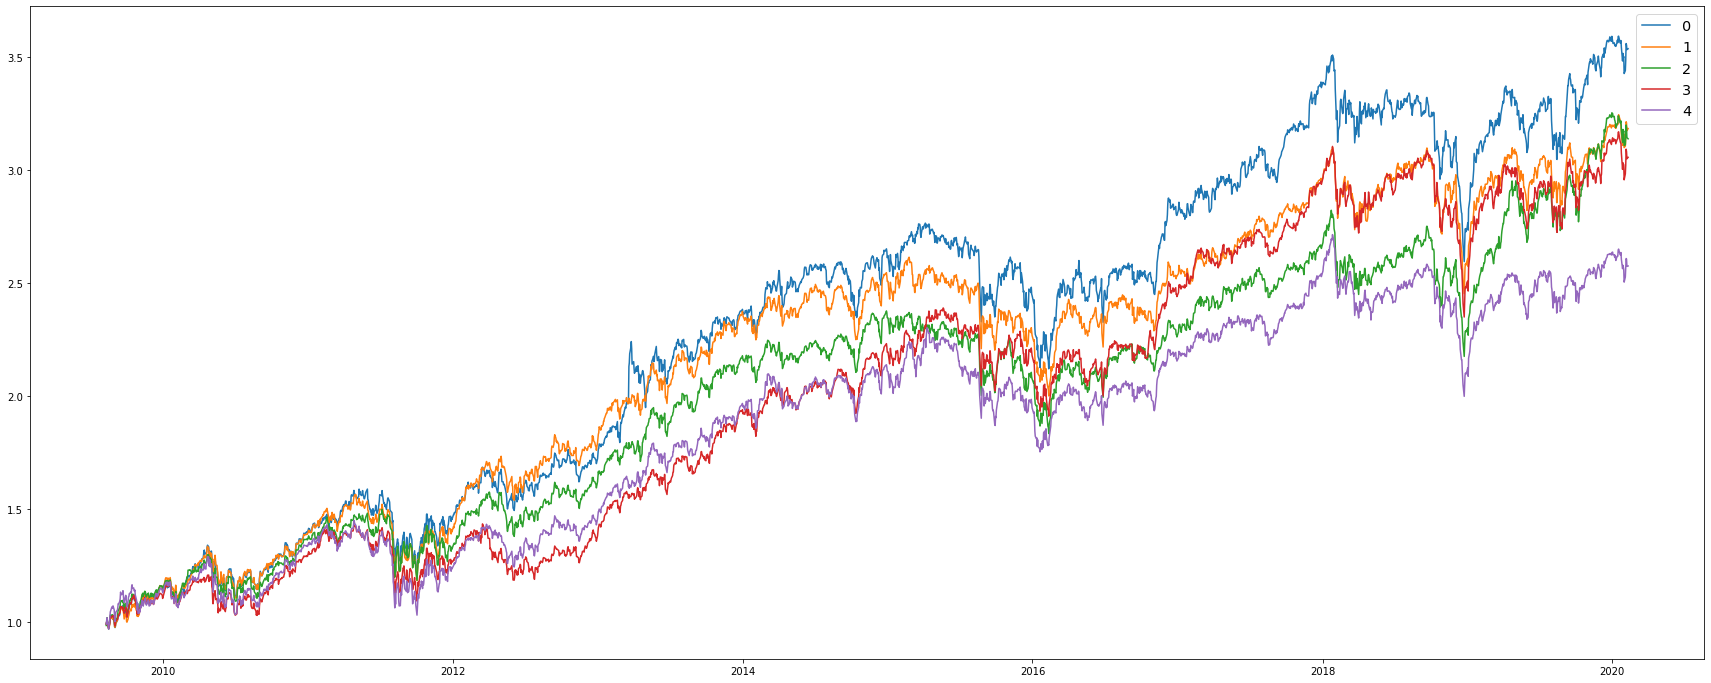

In [60]:
portfolio_us = Portfolio('snp_gram_index_w2v.csv', 10, 'future_grammar_perc')
backtester_us = Backtester(portfolio_us, 'D:\\data\\finance\\10kPlanet\\primary_stocks_us_price.csv', 'quantile')
print((backtester_us.portfolio_returns[0]+1).cumprod())
# plt.plot((backtester_us.portfolio_returns[0]+1).cumprod())
plt.figure(figsize=(30, 12))
for i in range(5):
    plt.plot((backtester_us.portfolio_returns[i]+1).cumprod(), label=i)
    plt.legend(fontsize='x-large')

C:\Users\sylim2357\anaconda3\envs\future-tense-mining\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\sylim2357\anaconda3\envs\future-tense-mining\lib\site-packages\ipykernel_launcher.py:100: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2009-07-21    1.005448
2009-07-22    1.004382
2009-07-23    1.034776
2009-07-24    1.044016
2009-07-27    1.046899
                ...   
2020-03-16         NaN
2020-03-17         NaN
2020-03-18         NaN
2020-03-19         NaN
2020-03-20         NaN
Length: 2671, dtype: float64


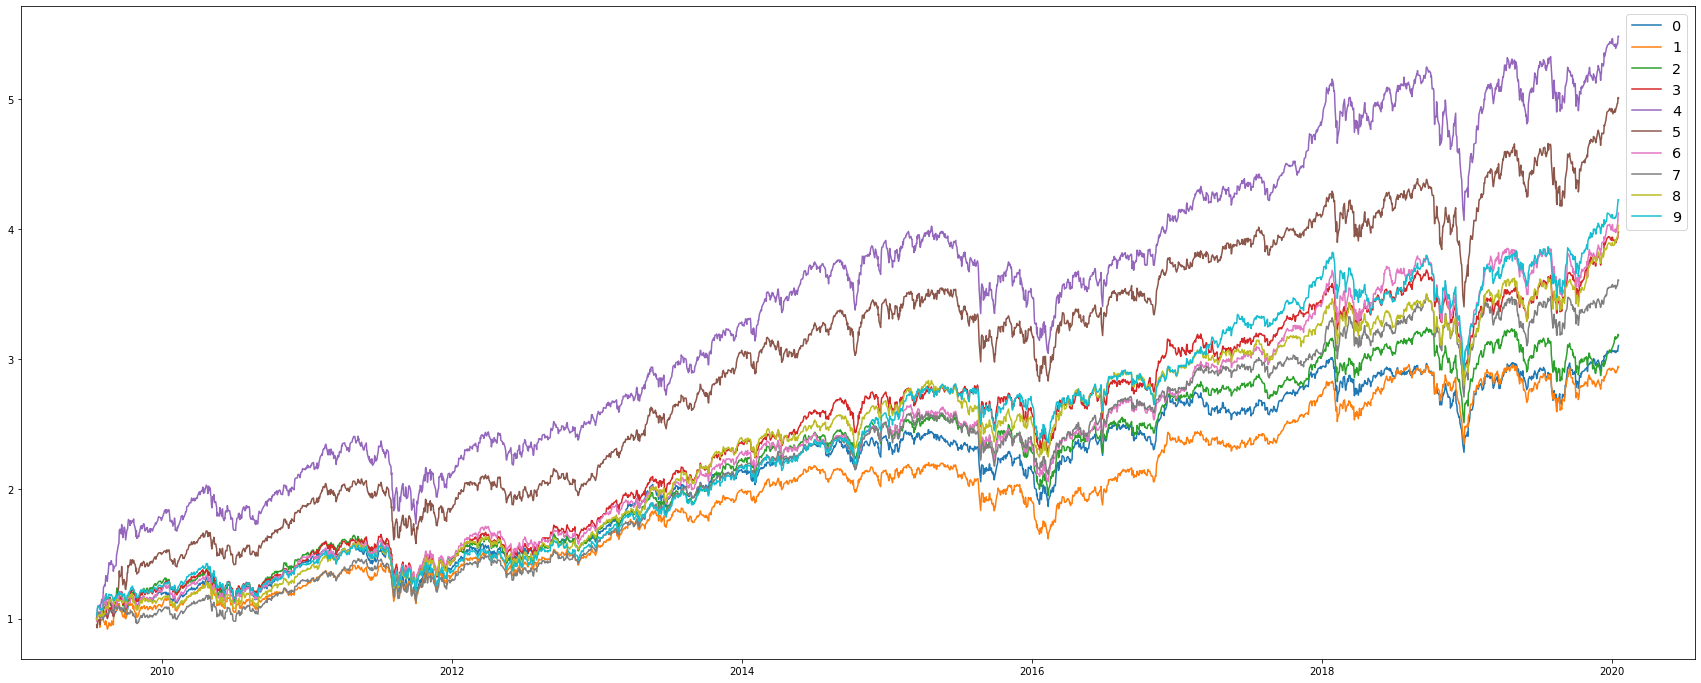

In [136]:
portfolio_us = Portfolio('10k_us_grammatical_index.csv', 10)
backtester_us = Backtester(portfolio_us, 'primary_stocks_us_price.csv', 'quantile')
print((backtester_us.portfolio_returns[0]+1).cumprod())
# plt.plot((backtester_us.portfolio_returns[0]+1).cumprod())
plt.figure(figsize=(30, 12))
for i in range(10):
    plt.plot((backtester_us.portfolio_returns[i]+1).cumprod(), label=i)
    plt.legend(fontsize='x-large')

5687
5673


C:\Users\sylim2357\anaconda3\envs\future-tense-mining\lib\site-packages\ipykernel_launcher.py:90: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\sylim2357\anaconda3\envs\future-tense-mining\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\sylim2357\anaconda3\envs\future-tense-mining\lib\site-packages\ipykernel_launcher.py:123: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2009-08-04    0.990814
2009-08-05    0.986532
2009-08-06    1.008658
2009-08-07    1.001406
2009-08-10    0.990307
                ...   
2020-01-27    3.846109
2020-01-28    3.831646
2020-01-29    3.818107
2020-01-30    3.743707
2020-01-31         NaN
Length: 2632, dtype: float64


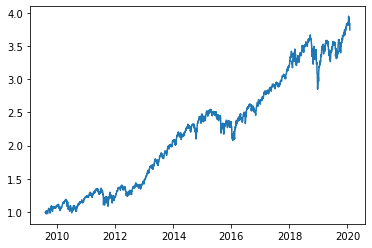

In [413]:
portfolio_us = Portfolio('..\\data\\10k_us_grammatical_index.csv', 4, 'ls')
backtester_us = Backtester(portfolio_us, 'D:\\data\\finance\\price\\north_america_price_08-19_raw.csv')
print((backtester_us.portfolio_returns+1).cumprod())
plt.plot((backtester_us.portfolio_returns+1).cumprod())

0
0


C:\Users\sylim2357\anaconda3\envs\future-tense-mining\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\sylim2357\anaconda3\envs\future-tense-mining\lib\site-packages\ipykernel_launcher.py:104: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0


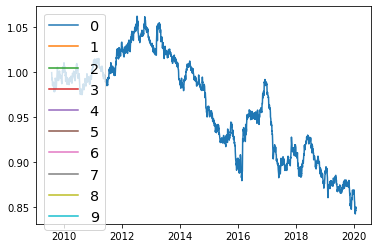

In [452]:
#adjust, right=False, original reb date, pivot
portfolio_us = Portfolio('..\\data\\10k_us_grammatical_index.csv', 10)
backtester_us = Backtester(portfolio_us, 'D:\\data\\finance\\price\\north_america_price_08-19_raw.csv', 'ls')
# print((backtester_us.portfolio_returns+1).cumprod())
for i in range(10):
    plt.plot((backtester_us.portfolio_returns[i]+1).cumprod(), label=i)
    plt.legend(fontsize='x-large')

0
0


C:\Users\sylim2357\anaconda3\envs\future-tense-mining\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\sylim2357\anaconda3\envs\future-tense-mining\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\sylim2357\anaconda3\envs\future-tense-mining\lib\site-packages\ipykernel_launcher.py:104: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4


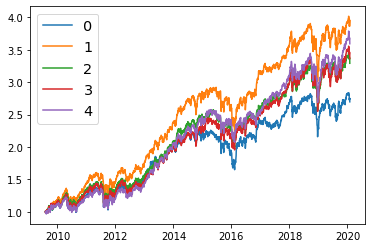

In [454]:
#adjust, right=False, original reb date, pivot
portfolio_us = Portfolio('..\\data\\10k_us_grammatical_index.csv', 5)
backtester_us = Backtester(portfolio_us, 'D:\\data\\finance\\price\\north_america_price_08-19_raw.csv', 'quantile')
# print((backtester_us.portfolio_returns+1).cumprod())
for i in range(5):
    plt.plot((backtester_us.portfolio_returns[i]+1).cumprod(), label=i)
    plt.legend(fontsize='x-large')

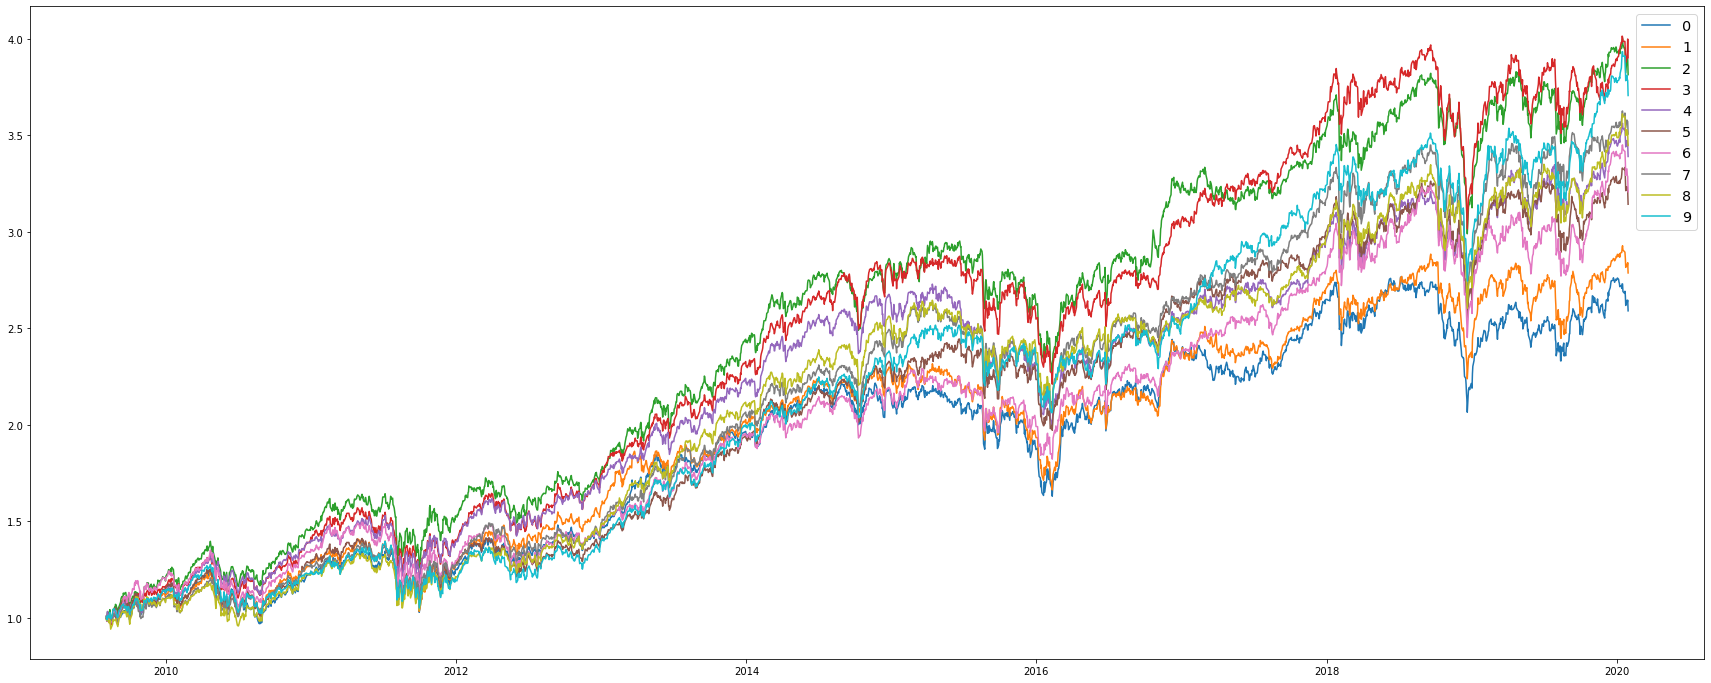

In [436]:
plt.figure(figsize=(30, 12))
for i in range(10):
    plt.plot((backtester_us.portfolio_returns[i]+1).cumprod(), label=i)
    plt.legend(fontsize='x-large')

C:\Users\sylim2357\anaconda3\envs\future-tense-mining\lib\site-packages\ipykernel_launcher.py:82: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\sylim2357\anaconda3\envs\future-tense-mining\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\sylim2357\anaconda3\envs\future-tense-mining\lib\site-packages\ipykernel_launcher.py:109: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2009-08-04    1.000860
2009-08-05    1.003019
2009-08-06    1.001225
2009-08-07    0.999676
2009-08-10    1.000904
                ...   
2020-01-27    3.941017
2020-01-28    3.959543
2020-01-29    3.956832
2020-01-30    3.968468
2020-01-31    3.939558
Length: 2632, dtype: float64


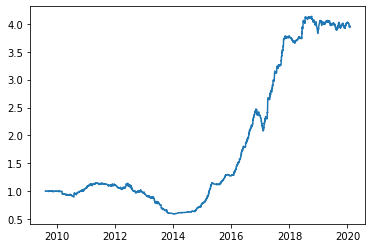

In [26]:
#adjust, right=False, original reb date, pivot
portfolio_us = Portfolio('..\\data\\10k_us_grammatical_index.csv', 4, 'ls')
backtester_us = Backtester(portfolio_us, 'D:\\data\\finance\\price\\north_america_price_08-19_raw.csv')
print((backtester_us.portfolio_returns+1).cumprod())
plt.plot((backtester_us.portfolio_returns+1).cumprod())

C:\Users\sylim2357\anaconda3\envs\future-tense-mining\lib\site-packages\ipykernel_launcher.py:82: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\sylim2357\anaconda3\envs\future-tense-mining\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\sylim2357\anaconda3\envs\future-tense-mining\lib\site-packages\ipykernel_launcher.py:109: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2009-08-04    1.000860
2009-08-05    1.003019
2009-08-06    1.001225
2009-08-07    0.999676
2009-08-10    1.000904
                ...   
2020-01-27    3.275357
2020-01-28    3.288766
2020-01-29    3.286126
2020-01-30    3.295362
2020-01-31    3.273234
Length: 2632, dtype: float64


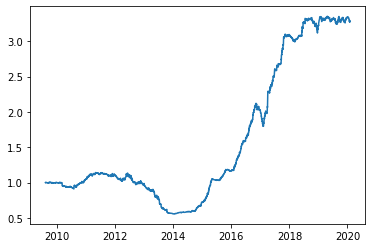

In [24]:
#adjust, right=changed reb date, forloop
portfolio_us = Portfolio('..\\data\\10k_us_grammatical_index.csv', 4, 'ls')
backtester_us = Backtester(portfolio_us, 'D:\\data\\finance\\price\\north_america_price_08-19_raw.csv')
print((backtester_us.portfolio_returns+1).cumprod())
plt.plot((backtester_us.portfolio_returns+1).cumprod())

In [13]:
#adjust, right=changed reb date
portfolio_us = Portfolio('..\\data\\10k_us_grammatical_index.csv', 4, 'ls')
backtester_us = Backtester(portfolio_us, 'D:\\data\\finance\\price\\north_america_price_08-19_raw.csv')
(backtester_us.portfolio_returns+1).cumprod()
plt.plot((backtester_us.portfolio_returns+1).cumprod())

C:\Users\sylim2357\anaconda3\envs\future-tense-mining\lib\site-packages\ipykernel_launcher.py:82: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\sylim2357\anaconda3\envs\future-tense-mining\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\sylim2357\anaconda3\envs\future-tense-mining\lib\site-packages\ipykernel_launcher.py:109: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2009-10-02    1.003021
2009-10-05    0.998486
2009-10-06    0.994695
2009-10-07    0.993406
2009-10-08    0.993019
                ...   
2019-12-24    2.338069
2019-12-26    2.342523
2019-12-27    2.340964
2019-12-30    2.340584
2019-12-31    2.344924
Length: 2560, dtype: float64

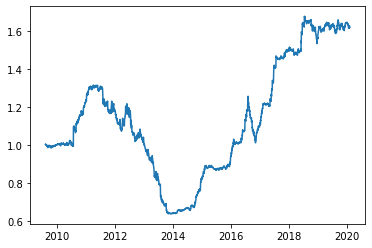

In [18]:
plt.plot((backtester_us.portfolio_returns+1).cumprod())

In [232]:
backtester_us = Backtester(portfolio_us, 'D:\\data\\finance\\price\\north_america_price_08-19_raw.csv')
(backtester_us.portfolio_returns+1).cumprod()

C:\Users\sylim2357\anaconda3\envs\future-tense-mining\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.
C:\Users\sylim2357\anaconda3\envs\future-tense-mining\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\sylim2357\anaconda3\envs\future-tense-mining\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2009-07-21    1.001531
2009-07-22    1.009074
2009-07-23    1.010429
2009-07-24    1.009148
2009-07-27    1.010037
                ...   
2020-01-13    2.794802
2020-01-14    2.796145
2020-01-15    2.786835
2020-01-16    2.790762
2020-01-17    2.790661
Length: 2629, dtype: float64

In [31]:
df_primary = pd.read_csv('D:\\data\\finance\\price\\Primary.csv', names=['gvkey', 'iid', 'col3', 'from', 'thru', 'iid-1', 'etc'])

# Primary Stock Filtering

In [54]:
df_primary = pd.read_csv('D:\\data\\finance\\price\\Primary.csv', names=['gvkey', 'iid', 'col3', 'from', 'thru', 'iid-1', 'etc'])
df_price = pd.read_csv('D:\\data\\finance\\price\\north_america_price_08-19_raw.csv')
stocks = set(df_us_10k.gvkey)
df_price_sp = df_price[df_price.gvkey.isin(stocks)]
df_primary_sp = df_primary[df_primary.gvkey.isin(stocks)]
df_primary_sp = df_primary_sp.drop_duplicates(['gvkey', 'iid', 'from', 'thru'])
df_primary_sp = df_primary_sp[~df_primary_sp.col3.str.contains('CAN')]
df_primary_sp = df_primary_sp.replace('2900-01-01 00:00:00.000000', '2020-04-05 00:00:00.000000')
df_primary_sp.loc[:, 'from'] = pd.to_datetime(df_primary_sp['from'])
df_primary_sp.loc[:, 'thru'] = pd.to_datetime(df_primary_sp['thru'])
df_price_sp.loc[:, 'datadate'] = pd.to_datetime(df_price_sp['datadate'], format='%Y%m%d')
#1이랑 01 잘 맞추기
df_price_sp['iid'] = df_price_sp['iid'].apply('{:0>2}'.format)
df_price_temp = df_price_sp.merge(df_primary_sp[['gvkey', 'iid', 'from', 'thru']], on=['gvkey', 'iid'])
df_price_temp[(df_price_temp.datadate >= df_price_temp['from']) & (df_price_temp.datadate <= df_price_temp.thru)].drop(['from', 'thru'], axis=1).to_csv('primary_stocks_us_price.csv', encoding='utf-8', index=False)

C:\Users\sylim2357\anaconda3\envs\future-tense-mining\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\sylim2357\anaconda3\envs\future-tense-mining\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\sylim2357\anaconda3\envs\future-tense-mining\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [76]:
df_price_temp = pd.read_csv('primary_stocks_us_price.csv', encoding='utf-8')